# 6. K-fold cross-validation (Part 2 - advanced training)

In [1]:
import numpy as np
import torch

In [2]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

In [3]:
# load dataset
from GPErks.serialization.labels import read_labels_from_file
data_dir = "data/example_4/"
X_ = np.loadtxt(data_dir + "X.txt", dtype=float)[:50]
y_ = np.loadtxt(data_dir + "y.txt", dtype=float)[:50]  # suppose we only have few points
xlabels = read_labels_from_file(data_dir + "xlabels.txt")
ylabel = read_labels_from_file(data_dir + "ylabel.txt")[0]

In [4]:
# split dataset in training and testing sets
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(
    X_,
    y_,
    test_size=0.5,
    random_state=seed
)

In [5]:
# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
    X,
    y,
    x_labels=xlabels,
    y_label=ylabel
)

In [6]:
# define experiment
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from torchmetrics import MeanSquaredError, R2Score

from GPErks.gp.experiment import GPExperiment
from GPErks.gp.mean import LinearMean

likelihood = GaussianLikelihood()
mean_function = LinearMean(degree=1, input_size=dataset.input_size, bias=True)
kernel = ScaleKernel(MaternKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError(), R2Score()]

experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,
    learn_noise=True,
)

/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# K-fold cross-validation training
from GPErks.perks.cross_validation import KFoldCrossValidation
from GPErks.train.early_stop import GLEarlyStoppingCriterion

device = "cpu"
devices = [device]
kfcv = KFoldCrossValidation(experiment, devices, n_splits=5)
# note: if we do not specify 'max_workers' above, the K-fold CV will
# automatically run in multiprocessing using all available cores

optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
esc = GLEarlyStoppingCriterion(max_epochs=1000, alpha=0.1, patience=8)
_, best_train_stats_dct = kfcv.train(
    optimizer, early_stopping_criterion=esc, leftout_is_val=True
)
# using this new flag 'leftout_is_val=True', we can utilize the respective leftout
# set of each split to stop the training using a validation loss-based early
# stopping criterion

# because of the used flag, the summary metrics below are not to be considered as
# reliable scores, because we are evaluating the accuracy against the leftout set
# used both as a validation and as a testing set
kfcv.summary()

INFO:2025-05-16 16:58:11,763:cross_validation:_train_split:L206: Running K-fold split 0...
INFO:2025-05-16 16:58:11,831:cross_validation:_train_split:L206: Running K-fold split 1...
INFO:2025-05-16 16:58:11,852:cross_validation:_train_split:L206: Running K-fold split 3...
INFO:2025-05-16 16:58:11,904:cross_validation:_train_split:L206: Running K-fold split 4...
INFO:2025-05-16 16:58:11,917:cross_validation:_train_split:L206: Running K-fold split 2...
INFO:2025-05-16 16:58:12,576:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:58:12,576:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 16:58:12,640:emulator:_train_once:L303: [   1/1000] Training Loss: 1.7785 - MeanSquaredError: 0.6871 - R2Score: 0.3129 | Validation Loss: 1.5033 - MeanSquaredError: 0.6815

                  Split 0  Split 1  Split 2  Split 3  Split 4    Mean     Std
MeanSquaredError   0.0023   0.0100   0.0158   0.0065   0.0034  0.0076  0.0049
R2Score            0.8574   0.7118   0.0137   0.8392   0.9423  0.6729  0.3377


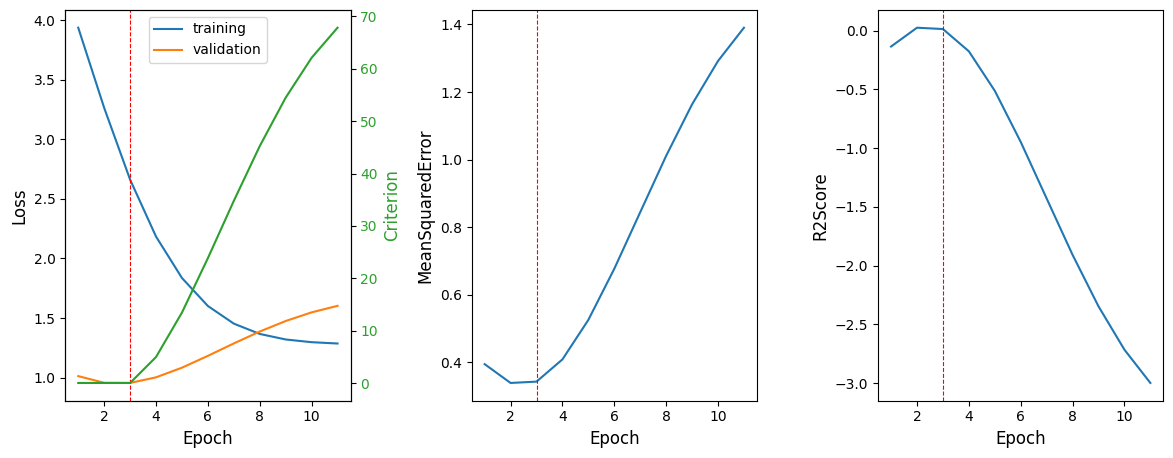

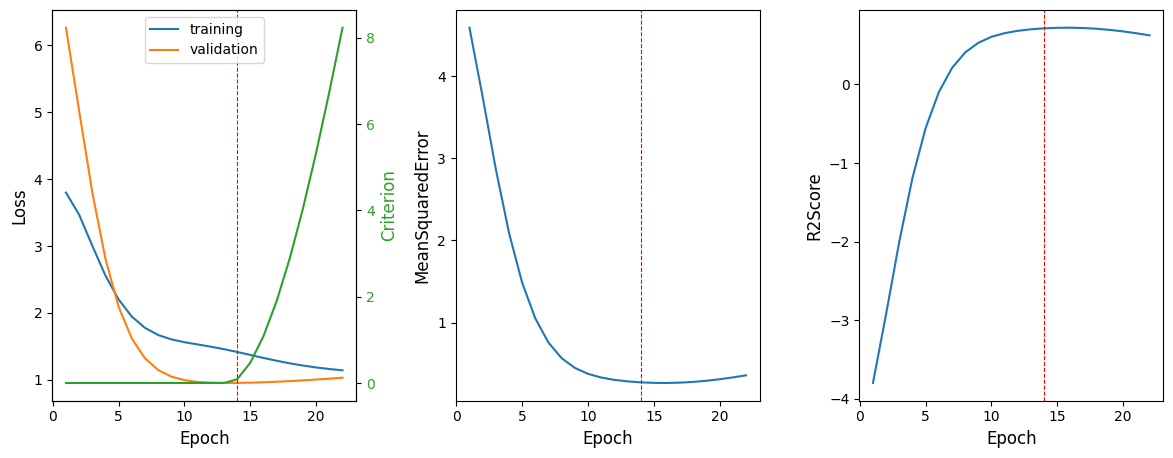

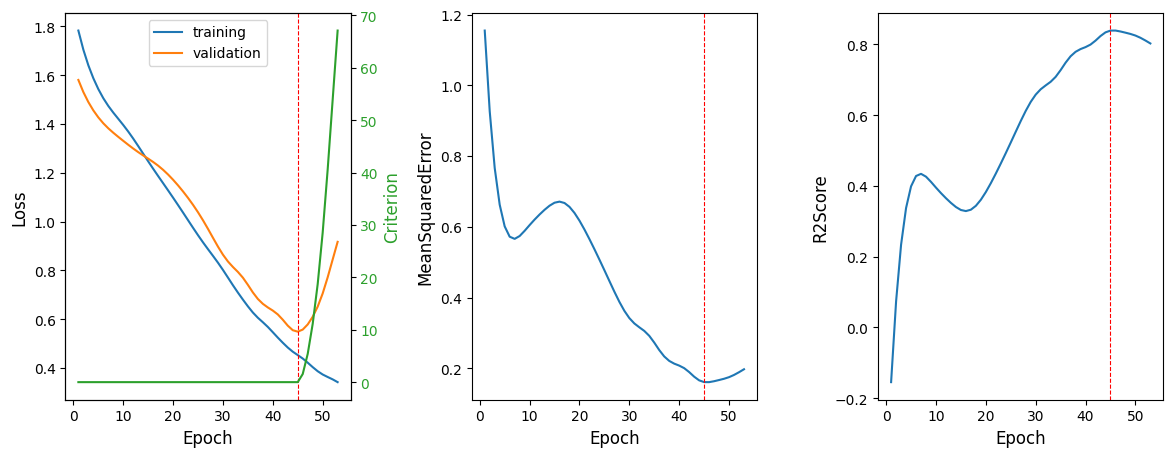

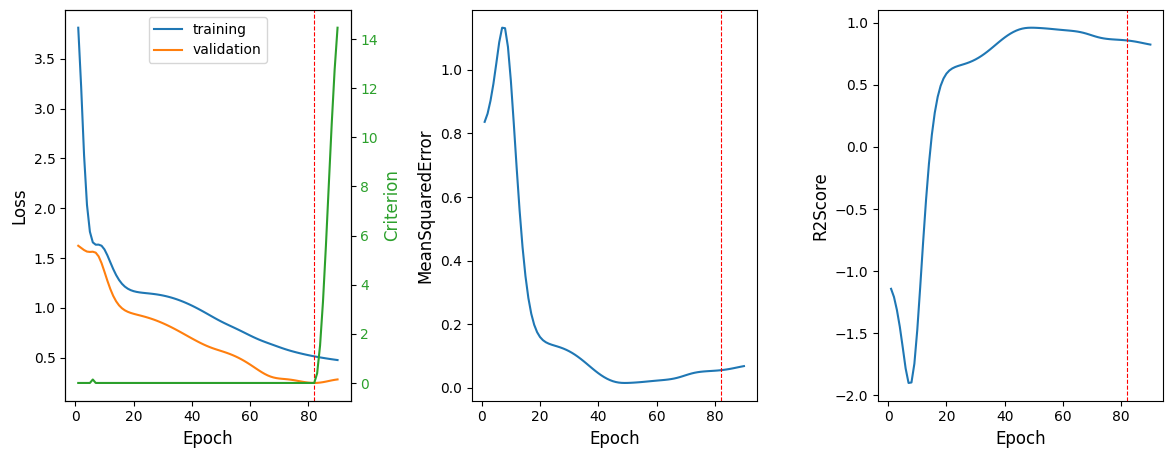

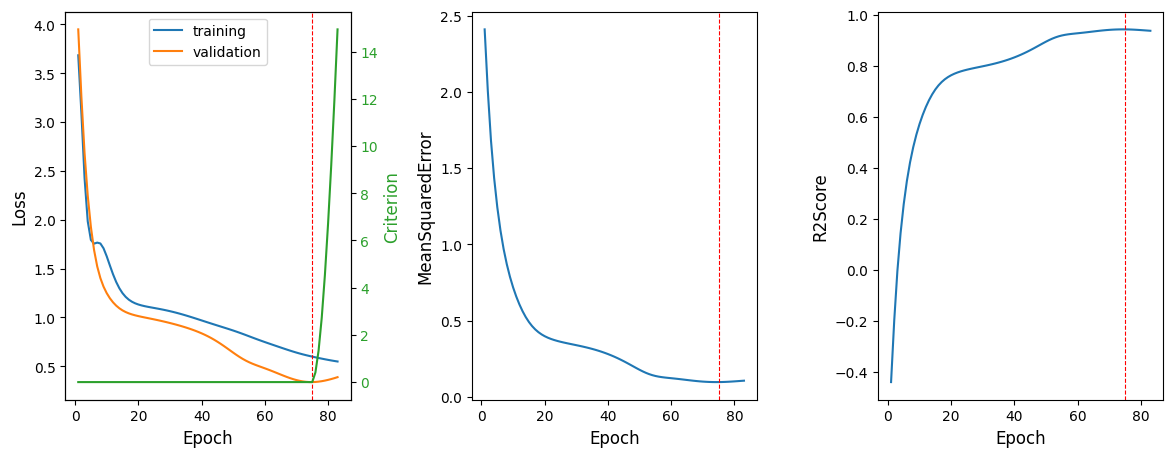

[3, 14, 45, 82, 75]

In [8]:
# check training stats at each split
best_epochs = []
for _, bts in best_train_stats_dct.items():
    bts.plot(with_early_stopping_criterion=True)
    best_epochs.append(bts.best_epoch)

# nevertheless, what we were really interested in was getting the stopping epoch
# reached at each split of the cross-validation
best_epochs

INFO:2025-05-16 16:58:15,855:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:58:15,857:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 16:58:15,929:emulator:_train_once:L303: [ 1/43] Training Loss: 2.3668 - MeanSquaredError: 0.8957 - R2Score: 0.1043
INFO:2025-05-16 16:58:15,942:emulator:_train_once:L303: [ 2/43] Training Loss: 1.9520 - MeanSquaredError: 0.7187 - R2Score: 0.2813
INFO:2025-05-16 16:58:15,947:emulator:_train_once:L303: [ 3/43] Training Loss: 1.7136 - MeanSquaredError: 0.6296 - R2Score: 0.3704
INFO:2025-05-16 16:58:15,953:emulator:_train_once:L303: [ 4/43] Training Loss: 1.5995 - MeanSquaredError: 0.5952 - R2Score: 0.4048
INFO:2025-05-16 16:58:15,958:emulator:_train_once:L303: [ 5/43] Training Loss: 1.5597 - MeanSquaredError: 0.5853 - R2S

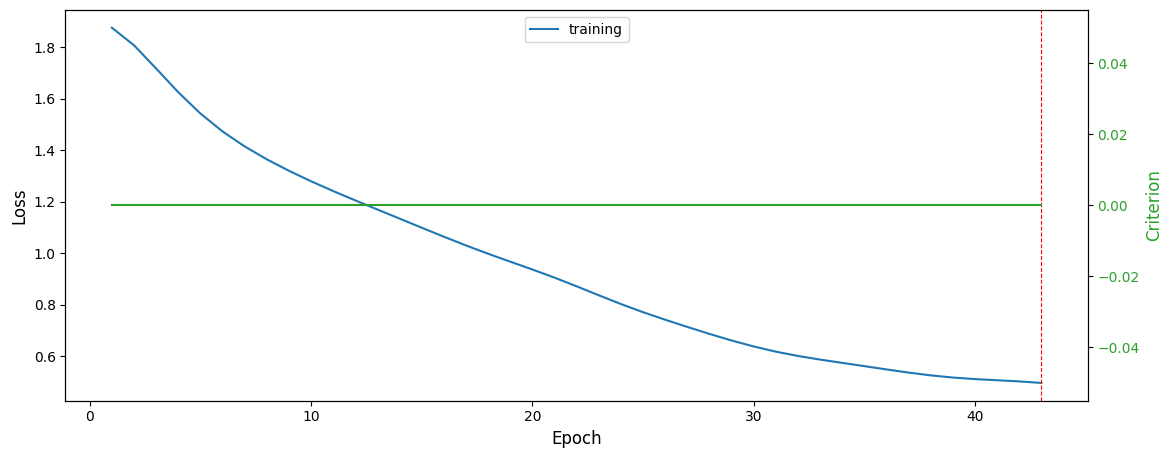

In [9]:
# train emulator on all the available points
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.emulator import GPEmulator

# build a new dataset now including a testing set
del dataset
dataset = Dataset(
    X, y, X_test=X_test, y_test=y_test, x_labels=xlabels, y_label=ylabel
)

likelihood = GaussianLikelihood()
mean_function = LinearMean(degree=1, input_size=dataset.input_size, bias=True)
kernel = ScaleKernel(MaternKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError(), R2Score()]

experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
)
device = "cpu"
emulator = GPEmulator(experiment, device)

optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

# making use of knowledge coming from the performed CV,
# we run the training for an exact number of epochs
max_epochs = int(np.mean(best_epochs))
esc = NoEarlyStoppingCriterion(max_epochs)

_, best_train_stats = emulator.train(optimizer, early_stopping_criterion=esc)

best_train_stats.plot(with_early_stopping_criterion=True)

                           Score
IndependentStandardError  1.0000
R2Score                   0.8972


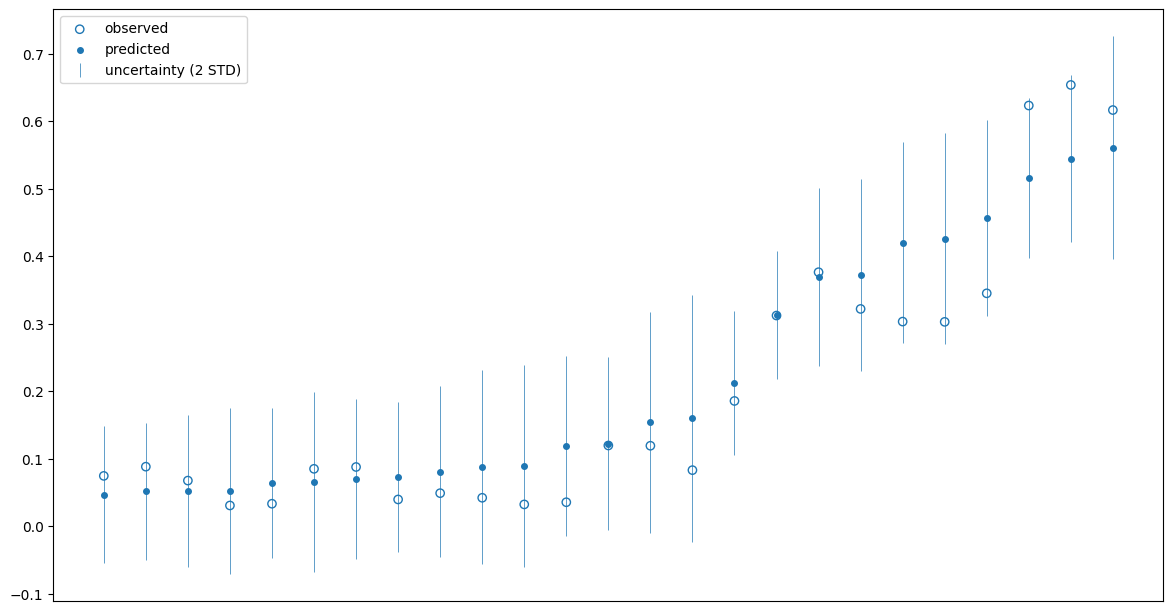

In [11]:
# note: we now support also ISE2 as a metric!
from GPErks.utils.metrics import IndependentStandardError

emulator.experiment.metrics = [IndependentStandardError(), R2Score()]

# we are achieving a very high R2Score using only 25 points and without a validation set, magic!
from GPErks.perks.inference import Inference

inference = Inference(emulator)
inference.summary()
inference.plot()